## Install

Install robustgp via pip:
```
pip install robustgp
```

## Import libraries

In [1]:
import robustgp

In [2]:
robustgp?

In [3]:
from robustgp import ITGP
import GPy
from matplotlib import pyplot as plt
import numpy as np

## Generate mock data

In [4]:
def neal_func(x):
    return 0.3 + 0.4 * x + 0.5 * np.sin(2.7 * x) + 1.1 / (1 + x**2)

np.random.seed(5)

# generate mock data
n = 200
noise = 0.2
n_outlier = 60
noise_outlier = 1

x_ob = np.random.rand(n) * 6 - 3
y_ob = neal_func(x_ob) + np.random.randn(n) * noise
y_ob[:n_outlier] = neal_func(x_ob[:n_outlier]) + np.random.randn(n_outlier) * noise_outlier

## Train ITGP

In [5]:
# run ITGP
res = ITGP(x_ob, y_ob,
           alpha1=0.5, alpha2=0.975, nsh=2, ncc=2, nrw=1,
           optimize_kwargs=dict(optimizer='lbfgsb')
           )
gp, consistency = res.gp, res.consistency

In [6]:
# consistency factor
print(consistency**0.5)

1.0838720595921671


In [7]:
# GPy.core.GP object
gp

ITGP_regression.,value,constraints,priors
rbf.variance,1.4888588994471008,+ve,
rbf.lengthscale,0.8875986623320775,+ve,
Gaussian_noise.variance,0.046814645071985676,+ve,


## Show results

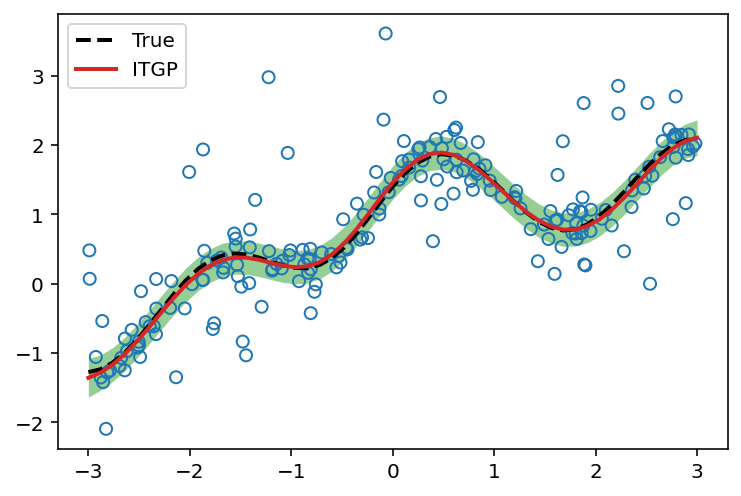

In [8]:
# check prediction on a grid
x = np.linspace(-3, 3, 51)
y_tr = neal_func(x)

# make prediction
y_avg, y_var = gp.predict(x.reshape(-1, 1))  # mean and variance
y_avg, y_var = y_avg.ravel(), y_var.ravel()  # flatten the array

y_var *= consistency  # consistency correction!
y_std = y_var ** 0.5

# plot
plt.scatter(x_ob, y_ob, facecolor='none', edgecolor='C0', zorder=-1)
plt.plot(x, y_tr, color='k', lw=2, ls='--', label='True')
plt.plot(x, y_avg, color='C3', lw=2, label='ITGP')
plt.fill_between(x, y_avg - y_std, y_avg + y_std, lw=0, color='C2', alpha=0.5, zorder=-2)

plt.legend()

In [9]:
# compare the predicted noise and the true noise of the main sample
print(noise, y_std.mean())

0.2 0.2424556388372694


## Advanced example

### Use custom kernels and set bounds of hyperparameters

In [10]:
# use a Matern52 kernel and use a white noise likelihood
kernel = GPy.kern.Matern52(input_dim=1, variance=1, lengthscale=1)
likelihood = GPy.likelihoods.Gaussian(variance=1)

# optional: set bounds of hyperparameters
kernel.lengthscale.constrain_bounded(0.1, 10, warning=False) 
kernel.variance.constrain_bounded(0, 10, warning=False)
likelihood.variance.constrain_bounded(0, 10, warning=False)

# run
res = ITGP(x_ob, y_ob,
           alpha1=0.5, alpha2=0.975, nsh=2, ncc=2, nrw=1,
           kernel=kernel, likelihood=likelihood,
           optimize_kwargs=dict(optimizer='lbfgsb')
           )
gp, consistency = res.gp, res.consistency

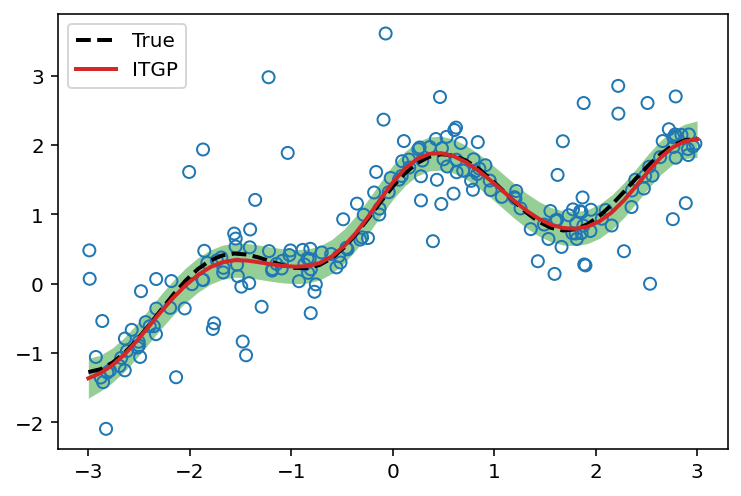

In [11]:
# plot
x = np.linspace(-3, 3, 51)
y_tr = neal_func(x)

y_avg, y_var = gp.predict(x.reshape(-1, 1))
y_avg, y_var = y_avg.ravel(), y_var.ravel()  # flatten the array

y_var *= consistency  # consistency correction!
y_std = y_var ** 0.5

plt.scatter(x_ob, y_ob, facecolor='none', edgecolor='C0', zorder=-1)
plt.plot(x, y_tr, color='k', lw=2, ls='--', label='True')
plt.plot(x, y_avg, color='C3', lw=2, label='ITGP')
plt.fill_between(x, y_avg - y_std, y_avg + y_std, lw=0, color='C2', alpha=0.5, zorder=-2)

plt.legend()